# 2688 Hybrid PCA denoising - improving PCA denoising in presence of spatially correlated noise

PCA denoising is becoming a popular pre-processing method to improve the precision of multidimensional MRI. For example, PCA denoising has already shown promiging results for diffusion MRI (1-7), MRI relaxometry (8,9), functional MRI (10-12), and magnetic resonance spectroscopy (13,14). 

### How PCA denoising works?

PCA denosing exploits the redundancy of signal across different MRI acquisitions. This technique can be performed iteratively using a sliding window (1). The selected data selected by the sliding window is reshaped to a $M \times N$ matrix $\textbf{X}$ in which $M$ corresponds to the number of voxels of the sliding window and $N$ the number of different MRI acquisitions. After applying the singular value decomposition of $\textbf{X}=\textbf{U}\Lambda\textbf{V}^T$, the denoising data $\textbf{X}_d$ is reconstructed from only significant PCA signal components $\textbf{X}_d=\textbf{U}\Lambda _d\textbf{V}^T$ with $\Lambda _d$ being a diagonal matrix containing only the eigenvalues of the selected PCA signal components.

### How to select noise and signal eigenvalues?

<ins> MP-PCA denoising:</ins>  Noise eigenvalues can be objectively classified by selecting the eigenvalues that best fits the Marchenko Pastur (MP) distribution (2). This is done by find the maximum number of lower eigenvalues which mean $\overline{\lambda}_c$  is larger than a noise variance estimate $\sigma ^2_{MP}$ that is iteratively computed from the MP distribution (2): 

$\overline{\lambda}_c \geq \sigma ^2_{MP} $

This approach, however, assumes that noise is spatially uncorrelated, which may not be the case of modern MRI system in which that spatial correlations may be introduced on reconstruction pipelines.

<ins> H-PCA denoising:</ins> in this study we propose the Hybrid H) PCA denoising. Instead of using an iterative MP process, the H-PCA denoising uses a noise variance prior $\sigma ^2_{prior} $. 

$\overline{\lambda}_c \leq \sigma ^2_{prior} $


The H-PCA denoising eigenvalue selection creteria can be mathematically justified. For the sake of simplicity, I did not add the derivations here; however, an intuitive explanation of the inequalty above is that  $\overline{\lambda}_c$ is only smaller than the noise variance if no significant signal component is included in the noise component group $\lambda _c$. In the submitted abstract to ISMRM (and in this notebook), we show that the performance of the Hybrid PCA is more robust to spatial correlations.

### Notebook content

In this notebook, we show how one can use the Hybrid PCA denoising in a human data set. For this example we use a dataset freely available in DIPY; however, this technique has the potential of being applied on other MRI datasets with multiple acquisitions, such as other diffusion MRI datasets, fMRI, MRS, etc. In this notebook, we also compare the performance of the H-PCA denoising to the previous state-of-the-art MP-PCA denoising proceudre. For an explanation on why H-PCA denoising outperforms the standard MP-PCA approach, please give a look to my ISMRM poster presentation (program number <ins> 2688</ins>). The code to reproduce the exact figures of the ISMRM abstract can be found on the other notebooks of this repository

# Showing the usage of H-PCA in diffusion MRI data

### Let's get started

The idea is to incorporate the H-PCA denoising technique on the open source package diffusion in python (DIPY). So, after installing DIPY according to the documentation in [DIPY](https://dipy.org/), you will be able expected to run this notebook with no problems.

Let's start by importing some modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames

Below, I am adding the main function to denoise the data. This function is implemented in a general way to be compatible with the previous denoising procedures in DIPY. After a code review on [DIPY's github](https://github.com/dipy/dipy), this function is ready to replace the existing denoising function in DIPY.

In [2]:
from dipy.denoise.localpca import _pca_classifier
from scipy.linalg import eigh

def _hybrid_classifier(L, varest):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. Hybrid PCA denoising
    """
    var = np.mean(L)
    c = L.size - 1
    while var > varest:
        var = np.mean(L[:c])
        c = c - 1
    ncomps = c + 1
    return var, ncomps


def genpca(arr, sigma=None, mask=None, patch_radius=2, pca_method='eig',
           tau_factor=None, return_sigma=False, out_dtype=None):
    r"""General function to perform PCA-based denoising of diffusion datasets.

    Parameters
    ----------
    arr : 4D array
        Array of data to be denoised. The dimensions are (X, Y, Z, N), where N
        are the diffusion gradient directions.
    sigma : float or 3D array (optional)
        Standard deviation of the noise estimated from the data. If no sigma
        is given, this will be estimated based on random matrix theory
        [1]_,[2]_
    mask : 3D boolean array (optional)
        A mask with voxels that are true inside the brain and false outside of
        it. The function denoises within the true part and returns zeros
        outside of those voxels.
    patch_radius : int or 1D array (optional)
        The radius of the local patch to be taken around each voxel (in
        voxels). Default: 2 (denoise in blocks of 5x5x5 voxels).
    pca_method : 'eig' or 'svd' (optional)
        Use either eigenvalue decomposition (eig) or singular value
        decomposition (svd) for principal component analysis. The default
        method is 'eig' which is faster. However, occasionally 'svd' might be
        more accurate.
    tau_factor : float (optional)
        If this variable is not None, thresholding of PCA eigenvalues is done
        by nulling out eigenvalues that are smaller than:

        .. math ::

                \tau = (\tau_{factor} \sigma)^2

        \tau_{factor} can be set to a predefined values (e.g. \tau_{factor} =
        2.3 [3]_). In case that the variable is not defined (i.e. in case that \tau_{factor} is set to None),
        tau_factor is calculated according MP-PCA distribution in case that noise variance
        is not give. If noise variance is given, hybrid PCA algorithm is used.
        Default: None.
    return_sigma : bool (optional)
        If true, the Standard deviation of the noise will be returned.
        Default: False.
    out_dtype : str or dtype (optional)
        The dtype for the output array. Default: output has the same dtype as
        the input.

    Returns
    -------
    denoised_arr : 4D array
        This is the denoised array of the same size as that of the input data,
        clipped to non-negative values

    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    .. [2] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    .. [3] Manjon JV, Coupe P, Concha L, Buades A, Collins DL (2013)
           Diffusion Weighted Image Denoising Using Overcomplete Local
           PCA. PLoS ONE 8(9): e73021.
           https://doi.org/10.1371/journal.pone.0073021
    """
    if mask is None:
        # If mask is not specified, use the whole volume
        mask = np.ones_like(arr, dtype=bool)[..., 0]

    if out_dtype is None:
        out_dtype = arr.dtype

    # We retain float64 precision, iff the input is in this precision:
    if arr.dtype == np.float64:
        calc_dtype = np.float64
    # Otherwise, we'll calculate things in float32 (saving memory)
    else:
        calc_dtype = np.float32

    if not arr.ndim == 4:
        raise ValueError("PCA denoising can only be performed on 4D arrays.",
                         arr.shape)

    if pca_method.lower() == 'svd':
        is_svd = True
    elif pca_method.lower() == 'eig':
        is_svd = False
    else:
        raise ValueError("pca_method should be either 'eig' or 'svd'")

    if isinstance(patch_radius, int):
        patch_radius = np.ones(3, dtype=int) * patch_radius
    if len(patch_radius) != 3:
        raise ValueError("patch_radius should have length 3")
    else:
        patch_radius = np.asarray(patch_radius).astype(int)
    patch_size = 2 * patch_radius + 1

    if np.prod(patch_size) < arr.shape[-1]:
        e_s = "You asked for PCA denoising with a "
        e_s += "patch_radius of {0} ".format(patch_radius)
        e_s += "with total patch size of {0}".format(np.prod(patch_size))
        e_s += "for data with {0} directions. ".format(arr.shape[-1])
        e_s += "This would result in an ill-conditioned PCA matrix. "
        e_s += "Please increase the patch_radius."
        raise ValueError(e_s)

    if isinstance(sigma, np.ndarray):
        var = sigma ** 2
        if not sigma.shape == arr.shape[:-1]:
            e_s = "You provided a sigma array with a shape"
            e_s += "{0} for data with".format(sigma.shape)
            e_s += "shape {0}. Please provide a sigma array".format(arr.shape)
            e_s += " that matches the spatial dimensions of the data."
            raise ValueError(e_s)
    elif isinstance(sigma, (int, float)):
        var = sigma ** 2 * np.ones(arr.shape[:-1])

    dim = arr.shape[-1]
    #if tau_factor is None:
    #    tau_factor = 1 + np.sqrt(dim / np.prod(patch_size))

    theta = np.zeros(arr.shape, dtype=calc_dtype)
    thetax = np.zeros(arr.shape, dtype=calc_dtype)
    ncall = np.zeros(arr.shape[:-1], dtype=calc_dtype)

    thetavar = np.zeros(arr.shape[:-1], dtype=calc_dtype)
    if return_sigma is True and sigma is None:
        var = np.zeros(arr.shape[:-1], dtype=calc_dtype)

    # loop around and find the 3D patch for each direction at each pixel
    for k in range(patch_radius[2], arr.shape[2] - patch_radius[2]):
        for j in range(patch_radius[1], arr.shape[1] - patch_radius[1]):
            for i in range(patch_radius[0], arr.shape[0] - patch_radius[0]):
                # Shorthand for indexing variables:
                if not mask[i, j, k]:
                    continue
                ix1 = i - patch_radius[0]
                ix2 = i + patch_radius[0] + 1
                jx1 = j - patch_radius[1]
                jx2 = j + patch_radius[1] + 1
                kx1 = k - patch_radius[2]
                kx2 = k + patch_radius[2] + 1

                X = arr[ix1:ix2, jx1:jx2, kx1:kx2].reshape(
                                np.prod(patch_size), dim)
                # compute the mean and normalize
                M = np.mean(X, axis=0)
                # Upcast the dtype for precision in the SVD
                X = X - M

                if is_svd:
                    # PCA using an SVD
                    U, S, Vt = svd(X, *svd_args)[:3]
                    # Items in S are the eigenvalues, but in ascending order
                    # We invert the order (=> descending), square and normalize
                    # \lambda_i = s_i^2 / n
                    d = S[::-1] ** 2 / X.shape[0]
                    # Rows of Vt are eigenvectors, but also in ascending
                    # eigenvalue order:
                    W = Vt[::-1].T

                else:
                    # PCA using an Eigenvalue decomposition
                    C = np.transpose(X).dot(X)
                    C = C / X.shape[0]
                    [d, W] = eigh(C, turbo=True)

                if sigma is None:
                    # Random matrix theory
                    this_var, ncomps = _pca_classifier(d, np.prod(patch_size))
                else:
                    # Predefined variance
                    this_var = np.mean(var[ix1:ix2, jx1:jx2, kx1:kx2])
                    if tau_factor is None:
                        this_var, ncomps = _hybrid_classifier(d, this_var)
                    else:
                        # tau_factor = 1 + np.sqrt(n / m)
                        tau = tau_factor ** 2 * this_var
                        # Update ncomps according to tau_factor
                        ncomps = np.sum(d < tau)

                W[:, :ncomps] = 0

                # This is equations 1 and 2 in Manjon 2013:
                Xest = X.dot(W).dot(W.T) + M
                Xest = Xest.reshape(patch_size[0],
                                    patch_size[1],
                                    patch_size[2], dim)
                # This is equation 3 in Manjon 2013:
                this_theta = 1.0 / (1.0 + dim - ncomps)
                theta[ix1:ix2, jx1:jx2, kx1:kx2] += this_theta
                thetax[ix1:ix2, jx1:jx2, kx1:kx2] += Xest * this_theta
                ncall[ix1:ix2, jx1:jx2, kx1:kx2] += (dim - ncomps) * this_theta
                thetavar[ix1:ix2, jx1:jx2, kx1:kx2] += this_theta
                
                if return_sigma is True and sigma is None:
                    var[ix1:ix2, jx1:jx2, kx1:kx2] += this_var * this_theta

    denoised_arr = thetax / theta
    denoised_arr.clip(min=0, out=denoised_arr)
    denoised_arr[mask == 0] = 0
    ncall = ncall / thetavar

    if return_sigma is True:
        if sigma is None:
            var = var / thetavar
            var[mask == 0] = 0
            return denoised_arr.astype(out_dtype), np.sqrt(var), ncall
        else:
            return denoised_arr.astype(out_dtype), sigma, ncall
    else:
        return denoised_arr.astype(out_dtype)

### Load and preparing data

Here, we use fetch to download a sample dataset that is provided by DIPY. The total size of the downloaded data is 87 MBytes; however, you only need to fetch it once.

In [3]:
fname, fbval, fbvec = get_fnames('stanford_hardi')

Bellow we plot the directories of the dMRI data files:

In [4]:
print(fname)
print(fbval)
print(fbvec)

C:\Users\rafae\.dipy\stanford_hardi\HARDI150.nii.gz
C:\Users\rafae\.dipy\stanford_hardi\HARDI150.bval
C:\Users\rafae\.dipy\stanford_hardi\HARDI150.bvec


<ins> Note:</ins> If you want to rerun this tutorial for data that you have acquired, you can manually define the variable fraw with your data directory.

Now that after having the data path, we can read it using the functions in dipy.io.

In [5]:
data, affine = load_nifti(fname)

bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (81, 106, 76, 160)


Below I am showing the bvalues acquired for this dataset. 

In [6]:
gtab.bvals

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000.,

This dataset was acquired for 10 b-value=0 acquisitions and 150 different diffusion directions for b-values=2000 s/mm2.

Before denoising the data, we first compute a brain mask that will be used to plot only data points on brain regions. This is done using DIPY's OTSU image segmentation:

In [7]:
maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=False, dilate=2)

### Compute noise standard deviation prior

The H-PCA denoising requires the estimation of a noise standard deviation prior. Below we calculate this prior from the standard deviation of repeated b-value=0 acquisitions.

In [8]:
S0s = data[:, :, :, gtab.b0s_mask]
stdS0 = np.std(S0s, axis=-1)

Below we plot the estimate of our noise standard deviation prior for a representative image slice. For a reference, we plot also the mean of b-value data and an estimate of data signal-to-noise-ratio map.

<ipython-input-9-b207826d3969>:2: RuntimeWarning: divide by zero encountered in true_divide
  SNR = meanS0 / stdS0
<ipython-input-9-b207826d3969>:2: RuntimeWarning: invalid value encountered in true_divide
  SNR = meanS0 / stdS0


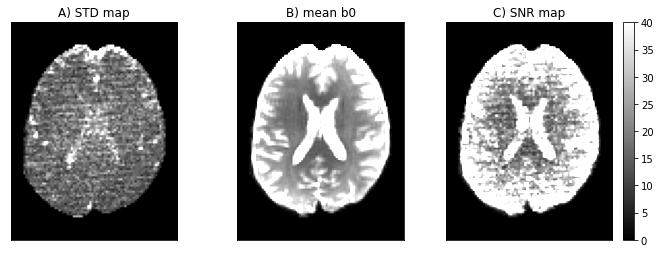

In [9]:
meanS0 = np.mean(S0s, axis=-1)
SNR = meanS0 / stdS0
stdS0_mask = stdS0.copy()
meanS0_mask = meanS0.copy()
stdS0_mask[mask==0] = 0 
meanS0_mask[mask==0] = 0 
SNR[mask==0] = 0 

axial_slice = 40
fig1, ax = plt.subplots(1, 3, figsize=(12, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(stdS0_mask[:, :, axial_slice].T, origin='lower', cmap='gray',
                  vmin=0, vmax=50)
ax.flat[0].set_title('A) STD map')

ax.flat[1].imshow(meanS0_mask[:, :, axial_slice].T, origin='lower', cmap='gray',
                 vmin=0, vmax=1000)
ax.flat[1].set_title('B) mean b0')

c = ax.flat[2].imshow(SNR[:, :, axial_slice].T, origin='lower', cmap='gray',
                  vmin=0, vmax=40)
ax.flat[2].set_title('C) SNR map')

fig1.colorbar(c, ax=ax.flat[2])

### Run denoising procedures

<ins> MP-PCA denoising:</ins> for a reference, let's run the standard MP-PCA denoising algorithm. For this, you need just to run the genpca procedure without inputing a noise standard deviation prior - this will basically produce the same output of the MP-PCA denoising algorithm already implemented in DIPY. Note, the parameter patch_radius is just to define the dimensions of the sliding window.

In [10]:
t = time()

den_mp = genpca(data, patch_radius=[3, 3, 3])

print("Time taken for MP-PCA ", -t + time())

C:\Users\rafae\anaconda3\envs\dipy_release\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rafae\anaconda3\envs\dipy_release\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Time taken for MP-PCA  3123.855082988739


<ins> H-PCA denoising:</ins> to run the Hybrid PCA denoising you have to rerun the genpca procedure but now inputing the noise standard deviation prior.

In [11]:
t = time()

den_hp = genpca(data, patch_radius=[3, 3, 3], sigma = stdS0)

print("Time taken for H-PCA ", -t + time())

Time taken for H-PCA  2368.493287086487


### Plot results

To illustrate the performance of the H-PCA denoised data, below we plot: 1) the raw data for a representative slice and diffusion gradient direction with b-value=2000s/mm2; 2) the denoised data for this representative data slice; and 3) the denoising residuals computed from the differences between raw and denoised data - larger residuals correspond to better denoising performances.

Text(0.5, 1.0, 'C) H-PCA Residuals')

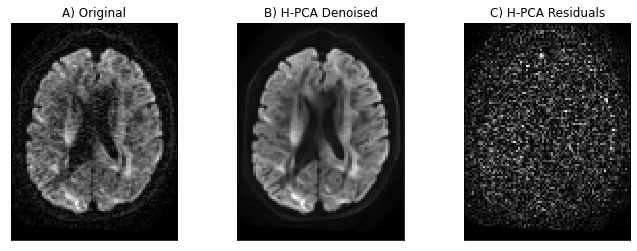

In [17]:
# Gets the center slice and the middle volume of the 4D diffusion data.
sli = axial_slice
gra = 60  # pick out a random volume for a particular gradient direction

orig = data[:, :, sli, gra]
den = den_hp[:, :, sli, gra]

# computes the residuals
rms_diff = np.sqrt((orig - den) ** 2)

fig1, ax = plt.subplots(1, 3, figsize=(12, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(orig.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[0].set_title('A) Original')
ax.flat[1].imshow(den.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[1].set_title('B) H-PCA Denoised')
ax.flat[2].imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[2].set_title('C) H-PCA Residuals')


The optimal denoising performance of the H-PCA algorithm can be apreciated by the reduction of the noise in the denoised data (panel B) than for the raw data (panel A). Moreover, no structural information is present on the residual maps showing that H-PCA denoising supresses the effects of noise without significantly removing spatial information.

Next, we produce the same plots for the MP-Denoising algorithm.

Text(0.5, 1.0, 'C) MP-PCA Residuals')

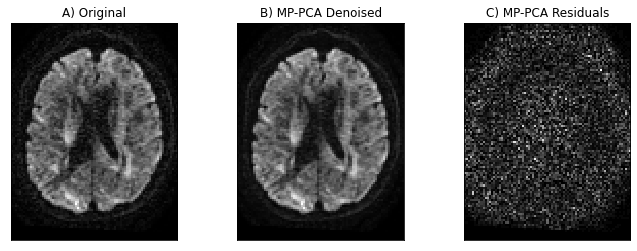

In [18]:
# Gets the center slice and the middle volume of the 4D diffusion data.
sli = axial_slice
gra = 60  # pick out a random volume for a particular gradient direction

orig = data[:, :, sli, gra]
den = den_mp[:, :, sli, gra]

# computes the residuals
rms_diff = np.sqrt((orig - den) ** 2)

fig1, ax = plt.subplots(1, 3, figsize=(12, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(orig.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[0].set_title('A) Original')
ax.flat[1].imshow(den.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[1].set_title('B) MP-PCA Denoised')
ax.flat[2].imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[2].set_title('C) MP-PCA Residuals')

The lower performance of the MP-PCA denoising procedure can be observed by the presence of residual noise in the Denoised map (panel B) and by the lower residuals present in the MP-PCA residuals (panel C) in comparison to the H-PCA residuals (c.f. panel C of the previous image).

### Discussion and Conclusions

In this tutorial, we show that the H-PCA denoising strategy can have a better performance than the MP-PCA denoising. In this specific dataset, noise is spatially correlated because it was corrupted by signal interpolation during image motion correction that was performed before it was added as a sample dataset in DIPY. In my ISMRM abstract, I also show an example of a pre-clinical dataset in which H-PCA denoising outperforms the MP-PCA denoising since data was acquired with defaults acquisition parameters that were set to optimize acquisition time (particularly by using partial Fourier acquisition and including k-space sampling during EPI ramps). Therefore, we conclude that H-PCA denoising algorithm can overcome issues of data corrupted by spatially correlated noise from image reconstruction pipelines or from previously applied pre-processing algorithms.

In future studies, we intend to evaluate the performance of our H-PCA denoising algorithm on other datasets (including other diffusion MRI, fMRI, MRI relaxometry, and MRS datasets). Moreover, we want to explore the compatibility of H-PCA denoising with other noise variance priors (e.g. 1, 15-17). This may be fundamental to expand the applicability of other denoising results to other datasets since these may not include multiple data acquisitions with the same parameters as multiple b-value=0 acquisitions.


### References

1. Manjón J V., Coupé P, Concha L, Buades A, Collins DL, Robles M. Diffusion Weighted Image Denoising Using Overcomplete Local PCA Gong G, editor. PLoS One 2013;8:e73021 doi: 10.1371/journal.pone.0073021.

2. Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers J, Fieremans E. Denoising of diffusion MRI using random matrix theory. Neuroimage 2016;142:394–406 doi: 10.1016/j.neuroimage.2016.08.016.

3. Shemesh N. Axon Diameters and Myelin Content Modulate Microscopic Fractional Anisotropy at Short Diffusion Times in Fixed Rat Spinal Cord. Front. Phys. 2018;0:49 doi: 10.3389/FPHY.2018.00049.

4. Ades-Aron B, Veraart J, Kochunov P, et al. Evaluation of the accuracy and precision of the diffusion parameter EStImation with Gibbs and NoisE removal pipeline. Neuroimage 2018;183:532–543 doi: 10.1016/j.neuroimage.2018.07.066.

5. Henriques RN, Correia MM, Marrale M, et al. Diffusional Kurtosis Imaging in the Diffusion Imaging in Python Project. Front. Hum. Neurosci. 2021;0:390 doi: 10.3389/FNHUM.2021.675433.

6. Tournier JD, Smith R, Raffelt D, et al. MRtrix3: A fast, flexible and open software framework for medical image processing and visualisation. Neuroimage 2019;202:116137 doi: 10.1016/J.NEUROIMAGE.2019.116137.

7. Moeller S, Pisharady PK, Ramanna S, et al. NOise reduction with DIstribution Corrected (NORDIC) PCA in dMRI with complex-valued parameter-free locally low-rank processing. Neuroimage 2021;226:117539 doi: 10.1016/J.NEUROIMAGE.2020.117539.

8. Does MD, Olesen JL, Harkins KD, et al. Evaluation of principal component analysis image denoising on multi-exponential MRI relaxometry. Magn. Reson. Med. 2019;81:3503–3514 doi: 10.1002/MRM.27658.

9. Bazin P-LL, Alkemade A, van der Zwaag W, Caan M, Mulder M, Forstmann BU. Denoising High-Field Multi-Dimensional MRI With Local Complex PCA. Front. Neurosci. 2019:1066.

10. Ades-Aron B, Lemberskiy G, Veraart J, et al. Improved task-based functional MRI language mapping in patients with brain tumors through marchenko-pastur principal component analysis denoising. Radiology 2020;298:365–373 doi: 10.1148/RADIOL.2020200822/ASSET/IMAGES/LARGE/RADIOL.2020200822.FIG6.JPEG.

11. Adhikari BM, Jahanshad N, Shukla D, et al. A resting state fMRI analysis pipeline for pooling inference across diverse cohorts: an ENIGMA rs-fMRI protocol. Brain Imaging Behav. 2019;13:1453–1467 doi: 10.1007/S11682-018-9941-X.

12. Diao Y, Yin T, Gruetter R, Jelescu IO. PIRACY: An Optimized Pipeline for Functional Connectivity Analysis in the Rat Brain. Front. Neurosci. 2021;15:285 doi: 10.3389/FNINS.2021.602170/BIBTEX.

13. Simões R V., Henriques RN, Cardoso BM, Fernandes FF, Carvalho T, Shemesh N. Glucose fluxes in glycolytic and oxidative pathways detected in vivo by deuterium magnetic resonance spectroscopy reflect proliferation in mouse glioblastoma. NeuroImage Clin. 2022;33:102932 doi: 10.1016/J.NICL.2021.102932.

14. Froeling M, Prompers JJ, Klomp DWJ, Velden TA van der. PCA denoising and Wiener deconvolution of 31P 3D CSI data to enhance effective SNR and improve point spread function. Magn. Reson. Med. 2021;85:2992–3009 doi: 10.1002/MRM.28654.

15. St-Jean S, De Luca A, Tax CMW, Viergever MA, Leemans A. Automated characterization of noise distributions in diffusion MRI data. Med. Image Anal. 2020;65:101758 doi: 10.1016/J.MEDIA.2020.101758.

16. Koay CG, Özarslan E, Pierpaoli C. Probabilistic Identification and Estimation of Noise (PIESNO): a self-consistent approach and its applications in MRI. J. Magn. Reson. 2009;199:94–103 doi: 10.1016/J.JMR.2009.03.005.

17. Tabelow K, Voss HU, Polzehl J. Local estimation of the noise level in MRI using structural adaptation. Med. Image Anal. 2015;20:76–86 doi: 10.1016/J.MEDIA.2014.10.008.